#Setting Up Kaggle

In [1]:
! pip install kaggle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! mkdir ~/.kaggle

In [4]:
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

#Downloading the Dataset


In [6]:
! kaggle datasets files nih-chest-xrays/data


Next Page Token = CfDJ8HYJ4SW6YXhJj8CRciRldeRzjtUv7ObdQ3pY3IKUhK3WdbqncAjrsFzqInL1wC4fdJ9rU1EStrgECVNBdEplq3k
name                                   size  creationDate                
----------------------------------  -------  --------------------------  
ARXIV_V5_CHESTXRAY.pdf              8963138  2019-09-24 23:56:19.481000  
BBox_List_2017.csv                    92416  2019-09-24 23:56:19.362000  
Data_Entry_2017.csv                 7861152  2019-09-24 23:56:19.543000  
FAQ_CHESTXRAY.pdf                     72223  2019-09-24 23:56:19.721000  
LOG_CHESTXRAY.pdf                      3919  2019-09-24 23:56:19.430000  
README_CHESTXRAY.pdf                 847223  2019-09-24 23:56:19.407000  
images_001/images/00000001_000.png   457171  2018-02-21 23:57:46.601000  
images_001/images/00000001_001.png   444655  2018-02-21 23:56:51.890000  
images_001/images/00000001_002.png   351772  2018-02-21 23:58:27.109000  
images_001/images/00000002_000.png   402332  2018-02-21 23:56:53.013000  
im

In [7]:
# install & authenticate
! pip install kaggle --quiet

# download & unzip the whole dataset
! kaggle datasets download -d nih-chest-xrays/data -p /content --unzip


Dataset URL: https://www.kaggle.com/datasets/nih-chest-xrays/data
License(s): CC0-1.0


#Install Dependencies and Setup

In [8]:
! pip install tensorflow opencv-python matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB ? eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 958.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 6.1 MB/s eta 0:00:00


In [9]:
import tensorflow as tf
import os

#Seperate Data Into Categories

In [10]:
import pandas as pd
import os
import shutil
from glob import glob
from tqdm import tqdm

# Load CSV
df = pd.read_csv('/content/Data_Entry_2017.csv')

# Build image-to-label dictionary
img_label_dict = pd.Series(df['Finding Labels'].values, index=df['Image Index']).to_dict()


In [11]:
df = pd.read_csv('/content/Data_Entry_2017.csv')
print(df.head())


        Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_000.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           58              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   
3           81              M            PA                 2500     2048   
4           81              F            PA                 2582     2991   

   OriginalImagePixelSpacing[x     y]  Unnamed: 11  
0                        0.143  0.143          NaN 

In [12]:
# code links each chest X-ray image to its corresponding disease labels from the NIH dataset
# and converts those labels into one-hot encoded vectors,
# preparing the data for multi-label classification
from glob import glob
import os, pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

categories = [
    'Atelectasis','Cardiomegaly','Effusion','Infiltration','Mass',
    'Nodule','Pneumonia','Pneumothorax','Consolidation','Edema',
    'Emphysema','Fibrosis','Pleural_Thickening','Hernia','No Finding'
]

png_paths = sorted(glob('/content/images_*/**/*.png', recursive=True))
print("Found", len(png_paths), "PNGs")

png_df = pd.DataFrame({'path': png_paths})
png_df['img_name'] = png_df['path'].astype(str).apply(os.path.basename)

csv = pd.read_csv('/content/Data_Entry_2017.csv',
                  usecols=['Image Index','Finding Labels'])
csv['labels'] = csv['Finding Labels'].str.split('|')

full_df = png_df.merge(csv, left_on='img_name', right_on='Image Index')

mlb = MultiLabelBinarizer(classes=categories)
full_df['label_vec'] = mlb.fit_transform(full_df['labels']).tolist()

print(full_df[['path', 'labels']].head())
print("Total matched images:", len(full_df))


Found 112120 PNGs
                                          path                     labels
0  /content/images_001/images/00000001_000.png             [Cardiomegaly]
1  /content/images_001/images/00000001_001.png  [Cardiomegaly, Emphysema]
2  /content/images_001/images/00000001_002.png   [Cardiomegaly, Effusion]
3  /content/images_001/images/00000002_000.png               [No Finding]
4  /content/images_001/images/00000003_000.png                   [Hernia]
Total matched images: 112120


#Load Data

In [13]:
def load_img(path, label_vec):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=1)
    img = tf.image.resize(img, [256, 256])
    img = tf.cast(img, tf.float32) / 255.
    return img, label_vec

paths  = tf.constant(full_df['path'].values)
labels = tf.constant(full_df['label_vec'].to_list(), dtype=tf.float32)

ds_train = (tf.data.Dataset.from_tensor_slices((paths, labels))
              .shuffle(len(paths), seed=123)
              .map(load_img, num_parallel_calls=tf.data.AUTOTUNE)
              .batch(256)
              .prefetch(tf.data.AUTOTUNE))


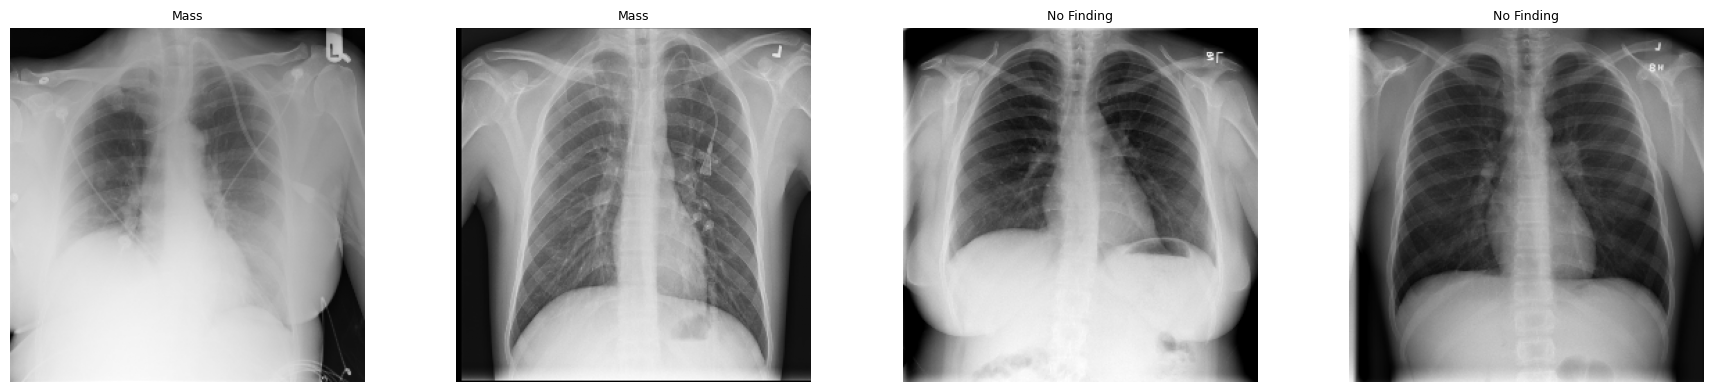

In [14]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

categories = [
    'Atelectasis','Cardiomegaly','Effusion','Infiltration','Mass',
    'Nodule','Pneumonia','Pneumothorax','Consolidation','Edema',
    'Emphysema','Fibrosis','Pleural_Thickening','Hernia','No Finding'
]

# get one batch
imgs, lbls = next(iter(ds_train))

# convert 0/1 vectors (comma‑separated label strings)
def vec_to_text(vec):
    active = [cat for cat, flag in zip(categories, vec) if flag]
    return ", ".join(active) if active else "No Finding"

lbl_txt = [vec_to_text(v.numpy()) for v in lbls[:4]]

# plot first 4 samples to be sure what we are looking at/accuracy
fig, ax = plt.subplots(1, 4, figsize=(18, 4))
for i in range(4):
    ax[i].imshow(imgs[i, ..., 0], cmap="gray")   # grayscale channel
    ax[i].set_title(lbl_txt[i], fontsize=9)
    ax[i].axis("off")
plt.tight_layout()
plt.show()


#Preprocess Data

In [15]:
# builds a basic CNN that takes in a check x-ray and tries to predict
# if any of the 15 categories are present
from tensorflow.keras import layers, models

def make_baseline(img_shape=(256, 256, 1), n_classes=15):
    inputs = layers.Input(img_shape)

    x = layers.Conv2D(32, 3, padding="same", activation="relu")(inputs)
    x = layers.MaxPool2D()(x)

    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.MaxPool2D()(x)

    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.MaxPool2D()(x)

    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.4)(x)

    outputs = layers.Dense(n_classes, activation="sigmoid")(x)
    return models.Model(inputs, outputs)



In [16]:
# load and prepare the image to be used by the model
def preprocess(path, label, augment=False):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=1)
    img = tf.image.resize(img, [256, 256])
    img = tf.image.grayscale_to_rgb(img)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img, label

In [17]:
# an improved CNN model from Google that will be better for final performance
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models

def make_efficientnet_rgb(img_shape=(256,256,3), n_classes=15,
                          train_backbone=False):
    inputs = layers.Input(img_shape)
    base = EfficientNetB0(include_top=False, weights="imagenet",
                          input_tensor=inputs, pooling="avg")
    base.trainable = train_backbone
    outputs = layers.Dense(n_classes, activation="sigmoid")(base.output)
    return models.Model(inputs, outputs)

model = make_efficientnet_rgb()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


#Test and Train Data

In [20]:
# Read NIH train/val and test lists
from pathlib import Path

root = Path("/content")
train_imgs = pd.read_csv(root/"train_val_list.txt", header=None)[0].tolist()
test_imgs  = pd.read_csv(root/"test_list.txt",      header=None)[0].tolist()

train_df = full_df[full_df["Image Index"].isin(train_imgs)].reset_index(drop=True)
test_df  = full_df[full_df["Image Index"].isin(test_imgs)].reset_index(drop=True)

In [27]:
!pip install iterative-stratification
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
import numpy as np

# 15 % multilabel‑stratified validation split within NIH train
X = train_df["path"].values
Y = np.stack(train_df["label_vec"].to_list())

msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=42)
train_idx, val_idx = next(msss.split(X, Y))

p_train, p_val = X[train_idx], X[val_idx]
y_train, y_val = Y[train_idx], Y[val_idx]

p_test  = test_df["path"].values
y_test  = np.stack(test_df["label_vec"].to_list())

print("Splits  Train:", len(p_train)," Val:", len(p_val)," Test:", len(p_test))


Splits  Train: 73494  Val: 13030  Test: 25596


In [28]:
# Build tf.data datasets (RGB, augment on train only)
AUTOTUNE = tf.data.AUTOTUNE
BATCH    = 256

def make_ds(paths, labels, augment):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if augment:
        ds = ds.shuffle(len(paths), seed=123)
    ds = ds.map(lambda p,l: preprocess(p, l, augment),
                num_parallel_calls=AUTOTUNE)
    return ds.batch(BATCH).prefetch(AUTOTUNE).cache()


In [29]:
train_ds = make_ds(p_train, y_train, augment=True)
val_ds   = make_ds(p_val,   y_val,   augment=False)
test_ds  = make_ds(p_test,  y_test,  augment=False)

print("Datasets rebuilt")

Datasets rebuilt


In [30]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

cb = [
    ModelCheckpoint(
        ".weights.h5",                     # file to save weights
        monitor="val_auc",
        mode="max",
        save_best_only=True,
        save_weights_only=True
    ),
    EarlyStopping(
        monitor="val_auc",
        mode="max",
        patience=5,                    # stop after 5 epochs w/out improvement
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor="val_auc",
        mode="max",
        factor=0.3,
        patience=2,                    # after 2 bad epochs
        min_lr=1e-6
    )
]

In [31]:
model = make_efficientnet_rgb(train_backbone=False)
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.AUC(multi_label=True, name='auc'),
        tf.keras.metrics.BinaryAccuracy(name='accuracy', threshold=0.5)
    ]
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=cb
)

Epoch 1/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 1186s 4s/step - accuracy: 0.9079 - auc: 0.5594 - loss: 0.2423 - val_accuracy: 0.9366 - val_auc: 0.6739 - val_loss: 0.1839 - learning_rate: 0.0010
Epoch 2/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 1187s 4s/step - accuracy: 0.9360 - auc: 0.6694 - loss: 0.1848 - val_accuracy: 0.9371 - val_auc: 0.7036 - val_loss: 0.1808 - learning_rate: 0.0010
Epoch 3/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 1227s 4s/step - accuracy: 0.9364 - auc: 0.6964 - loss: 0.1821 - val_accuracy: 0.9372 - val_auc: 0.7160 - val_loss: 0.1791 - learning_rate: 0.0010
Epoch 4/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 1228s 4s/step - accuracy: 0.9365 - auc: 0.7112 - loss: 0.1804 - val_accuracy: 0.9374 - val_auc: 0.7243 - val_loss: 0.1782 - learning_rate: 0.0010
Epoch 5/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 1221s 4s/step - accuracy: 0.9367 - auc: 0.7211 - loss: 0.1791 - val_accuracy: 0.9375 - val_auc: 0.7293 - val_loss: 0.1774 - learning_rate: 0.0010
Epoch 6/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 1228s 4s/step - accuracy: 0.93

#Fine-Tuning

In [35]:
import tensorflow as tf

# use focal loss instead of binary crossentropy
def focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
        pt = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        return tf.reduce_mean(alpha * tf.pow(1. - pt, gamma) * bce)
    return loss


In [36]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), #learning-rate changed
    loss=focal_loss(),
    metrics=[
        tf.keras.metrics.AUC(multi_label=True, name='auc'),
        tf.keras.metrics.BinaryAccuracy(name='accuracy', threshold=0.3)  # lowered threshold
    ]
)


In [37]:
history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=cb
)

Epoch 1/5
288/288 ━━━━━━━━━━━━━━━━━━━━ 1287s 4s/step - accuracy: 0.9292 - auc: 0.7568 - loss: 0.0222 - val_accuracy: 0.9168 - val_auc: 0.7513 - val_loss: 0.0186 - learning_rate: 1.0000e-05
Epoch 2/5
288/288 ━━━━━━━━━━━━━━━━━━━━ 1272s 4s/step - accuracy: 0.9111 - auc: 0.7618 - loss: 0.0173 - val_accuracy: 0.8926 - val_auc: 0.7551 - val_loss: 0.0157 - learning_rate: 1.0000e-05
Epoch 3/5
288/288 ━━━━━━━━━━━━━━━━━━━━ 1271s 4s/step - accuracy: 0.8884 - auc: 0.7644 - loss: 0.0150 - val_accuracy: 0.8736 - val_auc: 0.7586 - val_loss: 0.0146 - learning_rate: 1.0000e-05
Epoch 4/5
288/288 ━━━━━━━━━━━━━━━━━━━━ 1262s 4s/step - accuracy: 0.8709 - auc: 0.7650 - loss: 0.0142 - val_accuracy: 0.8621 - val_auc: 0.7594 - val_loss: 0.0142 - learning_rate: 1.0000e-05
Epoch 5/5
288/288 ━━━━━━━━━━━━━━━━━━━━ 1256s 4s/step - accuracy: 0.8617 - auc: 0.7660 - loss: 0.0139 - val_accuracy: 0.8577 - val_auc: 0.7617 - val_loss: 0.0141 - learning_rate: 1.0000e-05


#Plots for Results

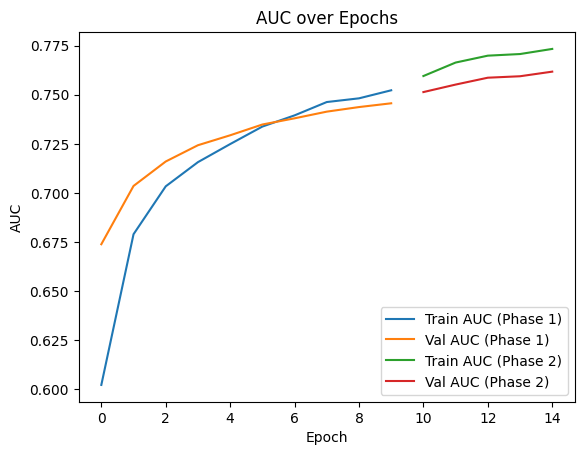

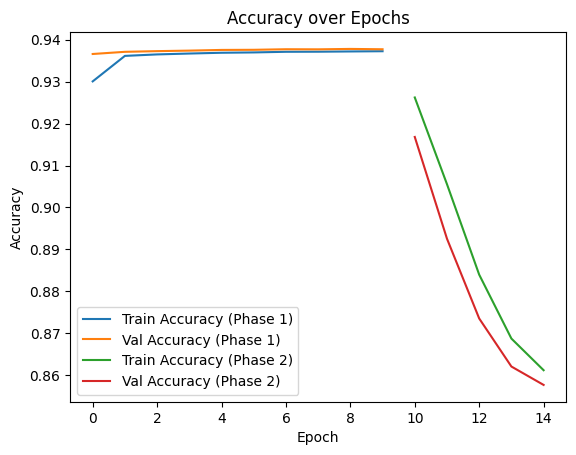

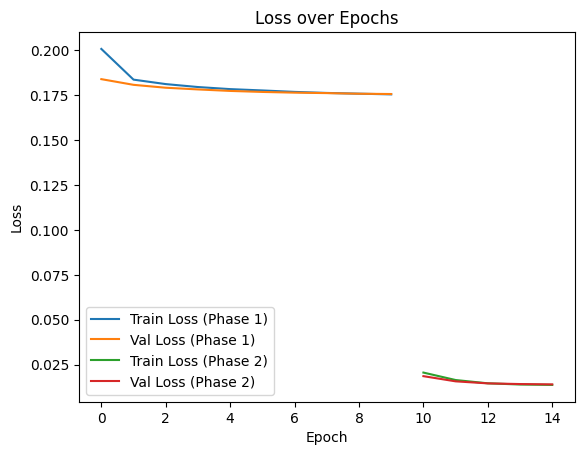

In [41]:
import matplotlib.pyplot as plt

# AUC Plot
plt.plot(history.history['auc'], label='Train AUC (Phase 1)')
plt.plot(history.history['val_auc'], label='Val AUC (Phase 1)')
plt.plot(
    range(len(history.history['auc']), len(history.history['auc']) + len(history_finetune.history['auc'])),
    history_finetune.history['auc'], label='Train AUC (Phase 2)')
plt.plot(
    range(len(history.history['val_auc']), len(history.history['val_auc']) + len(history_finetune.history['val_auc'])),
    history_finetune.history['val_auc'], label='Val AUC (Phase 2)')
plt.title('AUC over Epochs')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.show()

# Accuracy Plot

plt.plot(history.history['accuracy'], label='Train Accuracy (Phase 1)')
plt.plot(history.history['val_accuracy'], label='Val Accuracy (Phase 1)')
plt.plot(
    range(len(history.history['accuracy']), len(history.history['accuracy']) + len(history_finetune.history['accuracy'])),
    history_finetune.history['accuracy'], label='Train Accuracy (Phase 2)')
plt.plot(
    range(len(history.history['val_accuracy']), len(history.history['val_accuracy']) + len(history_finetune.history['val_accuracy'])),
    history_finetune.history['val_accuracy'], label='Val Accuracy (Phase 2)')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss Plot
plt.plot(history.history['loss'], label='Train Loss (Phase 1)')
plt.plot(history.history['val_loss'], label='Val Loss (Phase 1)')
plt.plot(
    range(len(history.history['loss']), len(history.history['loss']) + len(history_finetune.history['loss'])),
    history_finetune.history['loss'], label='Train Loss (Phase 2)')
plt.plot(
    range(len(history.history['val_loss']), len(history.history['val_loss']) + len(history_finetune.history['val_loss'])),
    history_finetune.history['val_loss'], label='Val Loss (Phase 2)')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


#Performance Metrics

In [38]:
from sklearn.metrics import precision_score, recall_score, f1_score

# After predictions
y_val_probs = model.predict(val_ds)
y_val_true = np.vstack([y for x, y in val_ds])

# Apply 0.3 threshold globally
y_pred_bin = (y_val_probs > 0.3).astype(int)

print("Precision:", precision_score(y_val_true, y_pred_bin, average='macro'))
print("Recall:", recall_score(y_val_true, y_pred_bin, average='macro'))
print("F1 Score:", f1_score(y_val_true, y_pred_bin, average='macro'))


51/51 ━━━━━━━━━━━━━━━━━━━━ 203s 4s/step
Precision: 0.1599696816250545
Recall: 0.3928383286196108
F1 Score: 0.2235468462029325


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [42]:
from sklearn.metrics import f1_score
import numpy as np

# get predictions and true labels
y_val_probs = model.predict(val_ds, verbose=1)
y_val_true = np.vstack([y for x, y in val_ds])

# tune thresholds
best_thresholds = []
for i in range(y_val_true.shape[1]):
    thresholds = np.linspace(0.05, 0.95, 50)
    f1s = [f1_score(y_val_true[:, i], (y_val_probs[:, i] > t).astype(int)) for t in thresholds]
    best_thresholds.append(thresholds[np.argmax(f1s)])

print("Best thresholds:", best_thresholds)


51/51 ━━━━━━━━━━━━━━━━━━━━ 197s 4s/step
Best thresholds: [np.float64(0.36224489795918363), np.float64(0.2887755102040816), np.float64(0.3438775510204081), np.float64(0.36224489795918363), np.float64(0.3438775510204081), np.float64(0.38061224489795914), np.float64(0.16020408163265304), np.float64(0.3438775510204081), np.float64(0.2887755102040816), np.float64(0.41734693877551016), np.float64(0.39897959183673465), np.float64(0.2520408163265306), np.float64(0.3255102040816326), np.float64(0.05), np.float64(0.39897959183673465)]


In [43]:
# apply per-class thresholds
y_pred_bin = np.array([
    (y_val_probs[:, i] > best_thresholds[i]).astype(int)
    for i in range(len(best_thresholds))
]).T

# re-evaluate
from sklearn.metrics import precision_score, recall_score, f1_score
print("Precision:", precision_score(y_val_true, y_pred_bin, average='macro'))
print("Recall:", recall_score(y_val_true, y_pred_bin, average='macro'))
print("F1 Score:", f1_score(y_val_true, y_pred_bin, average='macro'))


Precision: 0.18688748599176333
Recall: 0.35832660269202354
F1 Score: 0.23586547416674547
